In [85]:
# Important standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Importing packages used in data pre-processing
import gensim
from gensim.utils import simple_preprocess, tokenize
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
import string 
from tqdm import tqdm
from pprint import pprint
import time

# Preparing data
1. Loading data and dropping irrelevant columns
2. Removal of NaN values from relevant attributes
3. Create new dataframe consisting of only keywords and country ID

In [87]:
data=pd.read_csv("FAOLEX_All.csv")
# print(data.keys())
# print(df.info())
# print(keywords[:5])

# Create simplified version of the dataframe by discarding irrelevant columns 
to_drop = ['Record Id', 
           'Record URL', 
           'Document URL', 
           'Title',
           'Original title',
           'Available website',
           'Abstract']

data.drop(to_drop, inplace=True, axis=1)

In [89]:
# Remove NaN values in the Countries/Territory and Keywords attributes 
data_no_nan = data.dropna(subset=["Country/Territory", "Keywords"])
print(f"This results in {len(data) - len(data_no_nan)} rows being dropped")
print(len(data_no_nan))

This results in 939 rows being dropped
195498


In [90]:
# Remove all documents that have been repealed (Repealed == Y)
data_no_repealed = data_no_nan[data_no_nan.Repealed != 'Y']
print(len(data_no_nan) - len(data_no_repealed))
print(len(data_no_repealed))


23106
172392


In [31]:
data_kw = data_no_repealed[["Country/Territory","Keywords"]]
data_kw['index'] = data_kw.index
keywords = data_kw

/var/folders/sb/klhtpy1n7jd649__g8r7xj300000gn/T/ipykernel_2014/4047462888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kw['index'] = data_kw.index


In [84]:
len(keywords)

172392

# Data pre-processing (v2)
**IMPORTANT**: This is the version of the data pre-processing that should be applied - do not use v1

In [32]:
tokenizer = RegexpTokenizer(r'\w+') # create tokenizer to tokenize docs 
stop_words = stopwords.words('english') # create list of stopwords
p_stemmer = PorterStemmer() # create stemmer instance 


In [33]:
doc_set = keywords["Keywords"].tolist()
processed_kw_list = []

# loop through document list
for i in tqdm(doc_set):
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    processed_kw_list.append(stemmed_tokens)
    #processed_kw_list.append(stopped_tokens)
    


100%|██████████| 172392/172392 [00:25<00:00, 6755.78it/s]


In [9]:
processed_kw_list

[['maritim', 'zone', 'territori', 'sea', 'sovereignti'],
 ['territori',
  'sea',
  'maritim',
  'zone',
  'eez',
  'exclus',
  'econom',
  'zone',
  'zone'],
 ['fisheri',
  'manag',
  'conserv',
  'marin',
  'fisheri',
  'foreign',
  'fish',
  'territori',
  'sea',
  'navig',
  'maritim',
  'zone',
  'access',
  'right',
  'sovereignti'],
 ['non', 'government', 'entiti', 'intern', 'trade'],
 ['harbour', 'navig', 'harbour', 'navig'],
 ['maritim',
  'zone',
  'eez',
  'exclus',
  'econom',
  'zone',
  'territori',
  'sea',
  'continent',
  'shelf',
  'navig',
  'sovereignti',
  'enforc',
  'complianc',
  'offenc',
  'penalti'],
 ['marin',
  'fisheri',
  'territori',
  'sea',
  'maritim',
  'zone',
  'eez',
  'exclus',
  'econom',
  'zone',
  'sovereignti',
  'navig',
  'offenc',
  'penalti',
  'plastic'],
 ['marin',
  'fisheri',
  'enforc',
  'complianc',
  'manag',
  'conserv',
  'protect',
  'area'],
 ['marin',
  'pollut',
  'marin',
  'fisheri',
  'protect',
  'fish',
  'area',
  'enf

In [10]:
s = "maritime zone; territorial sea; sovereignty"
print(s)
print(tokenizer.tokenize(s))

maritime zone; territorial sea; sovereignty
['maritime', 'zone', 'territorial', 'sea', 'sovereignty']


# Data pre-processing (v1)
1. Create various pre-processing functions
2. Perform the pre-processing on the simplified dataframe created above
3. Stopwords removal
4. Lemmatization (yet to be done)

In [6]:
# Create function to remove punctuation from input text
def remove_punctuation(text):
    # signs = ";'-"
    signs = ";"
    #return "".join([i for i in text if i not in string.punctuation])
    
    return "".join([i for i in text if i not in signs])

'''
def remove_stop_words(text): 
    for word in text: 
        if word in stop_words: 
            text = text.replace(word, '')
    return text
'''


# Create function to do data pre-processing (excluding stop word removal and lemmatization)
def pre_process(text):
    text = remove_punctuation(text)
    # text = remove_stop_words(text)
    text = text.lower()
    processed = list(tokenize(text))
    
    return processed


In [7]:
# Performing pre-processsing 
processed_kw = keywords["Keywords"].map(pre_process)

# Convert to a list
processed_kw_list = processed_kw.values.tolist()

# Remove stop words
stop_words = stopwords.words('english')
for lists in processed_kw_list:
    for kw in lists: 
        if kw in stop_words:
            lists.remove(kw)

# Lemmatization 
# TODO figure out a way to do this 


# LDA model

In [34]:
# Mapping from word IDs to words
# https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
id2word = corpora.Dictionary(processed_kw_list)

# Prepare Document-Term matrix
corpus = []
for doc in processed_kw_list:
    corpus.append(id2word.doc2bow(doc))

In [35]:
# Creating the LDA model
n_topics = 19
# Documentation: https://radimrehurek.com/gensim/models/ldamodel.html
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                            id2word = id2word, 
                                            num_topics=n_topics, 
                                            random_state=100, 
                                            passes = 20)
'''
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus, 
                                            id2word = id2word, 
                                            num_topics=n_topics, 
                                            random_state=100, 
                                            passes = 50)


In [17]:
pprint(lda_model.print_topics(num_topics=5))


[(17,
  '0.212*"plant" + 0.075*"product" + 0.068*"protect" + 0.051*"pest" + '
  '0.045*"materi" + 0.045*"seed" + 0.037*"diseas" + 0.030*"edibl" + '
  '0.029*"fruit" + 0.029*"nut"'),
 (1,
  '0.203*"storag" + 0.203*"transport" + 0.080*"matter" + 0.080*"procedur" + '
  '0.066*"mine" + 0.040*"fertil" + 0.040*"nutrient" + 0.037*"explor" + '
  '0.036*"oil" + 0.036*"miner"'),
 (7,
  '0.279*"intern" + 0.194*"agreement" + 0.095*"text" + 0.078*"implement" + '
  '0.056*"cooper" + 0.030*"mark" + 0.030*"identif" + 0.030*"research" + '
  '0.021*"transboundari" + 0.021*"effect"'),
 (21,
  '0.177*"polici" + 0.176*"plan" + 0.151*"govern" + 0.148*"public" + '
  '0.068*"health" + 0.059*"local" + 0.047*"institut" + 0.045*"particip" + '
  '0.021*"monitor" + 0.017*"precautionari"'),
 (0,
  '0.210*"protect" + 0.109*"area" + 0.097*"conserv" + 0.067*"speci" + '
  '0.062*"ecosystem" + 0.049*"wild" + 0.044*"manag" + 0.035*"biodivers" + '
  '0.031*"habitat" + 0.030*"cultur"')]


In [75]:
# Compute Coherence Score (the higher the better)
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5151338788032372


In [53]:
# WARNING: takes potentially multiple hours to run!!! 
# Create function to find optimal topic_num to use in LDA model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_cv = []
    coherence_values_umass = []
    model_list = []
    for topic_n in tqdm(range(start, limit, step)):
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes = 5)
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes=5)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_cv.append(coherencemodel.get_coherence())
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values_umass.append(coherencemodel.get_coherence())

    return model_list, coherence_values_cv, coherence_values_umass 

# Trying to find optimal number of topics

In [55]:
# Finding the optimal number of topics by creating multiple LDA models and computing coherence score
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 35
start = 5
step = 2

model_list, coherence_values_cv, coherence_values_umass = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

100%|██████████| 15/15 [04:56<00:00, 19.75s/it]


In [17]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: name 'start' is not defined

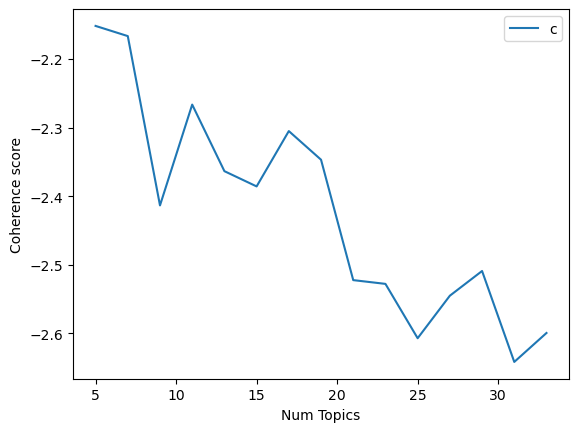

In [58]:
x = range(start, limit, step)
plt.plot(x, coherence_values_umass)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
model_numbers = range(start, limit, step)
for i in range(len(model_list)):
    # coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=model_list[i], texts=processed_kw_list, dictionary=id2word, coherence='c_v')
    # coherence_lda = coherence_model_lda.get_coherence()
    # print(f"The model with {i+5} topics has a coherence score of {coherence_lda}")
    print(f"The model with {model_numbers[i]} topics has a coherence score of {coherence_values_cv[i]}")

The model with 5 topics has a coherence score of 0.6246419806530596
The model with 7 topics has a coherence score of 0.6736080668496122
The model with 9 topics has a coherence score of 0.6833934333472556
The model with 11 topics has a coherence score of 0.702878312068639
The model with 13 topics has a coherence score of 0.7026016128972115
The model with 15 topics has a coherence score of 0.7178841499407255
The model with 17 topics has a coherence score of 0.7371764114770849
The model with 19 topics has a coherence score of 0.7396059189992742
The model with 21 topics has a coherence score of 0.7261920543590177
The model with 23 topics has a coherence score of 0.72481048377023
The model with 25 topics has a coherence score of 0.7163995303438178
The model with 27 topics has a coherence score of 0.7114739744735772
The model with 29 topics has a coherence score of 0.7236998047163736
The model with 31 topics has a coherence score of 0.7052626993417087
The model with 33 topics has a coherence

In [76]:
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 100
start = 70
step = 3

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

100%|██████████| 10/10 [24:12<00:00, 145.22s/it]


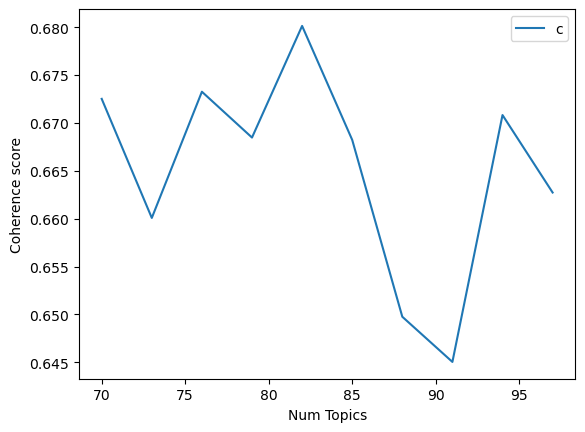

In [77]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 110 
start = 70
step = 2

models = []
coherences = []
for i in tqdm(range(3)): 
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)
    models.append(model_list)
    coherences.append(coherence_values)

100%|██████████| 3/3 [5:23:24<00:00, 6468.32s/it]  


In [105]:
# Fixes mistake made in above loop where coherence appended itself. The issue above has also been fixed, so this is only applicaple one time. 
models_copy = models.copy()
coherences = []
for run in tqdm(models_copy, desc="Outer", position=0):
    coherences_run = []
    for model in tqdm(run, desc=" Inner loop", position=1, leave=False): 
        time.sleep(0.05)
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherences_run.append(coherence_lda)
    coherences.append(coherences_run)


Outer: 100%|██████████| 3/3 [10:24<00:00, 208.07s/it]


In [107]:
# Create list of average coherence values 
avg_coherence_values = []

for i in range(len(coherence_values)): 
    total_i = coherences[0][i] + coherences[1][i] + coherences[2][i]
    avg_i = total_i / 3
    avg_coherence_values.append(avg_i)

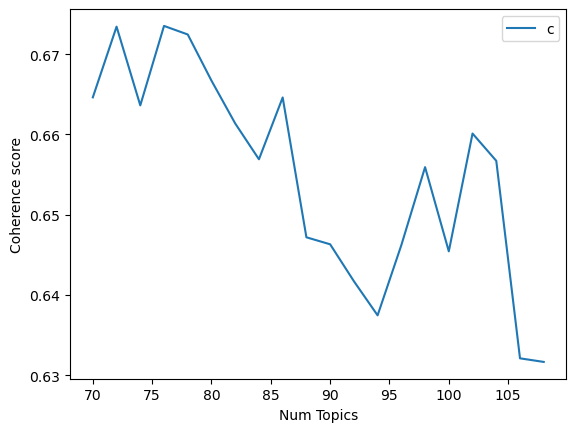

In [108]:
limit = 110 
start = 70
step = 2

x = range(start, limit, step)
plt.plot(x, avg_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

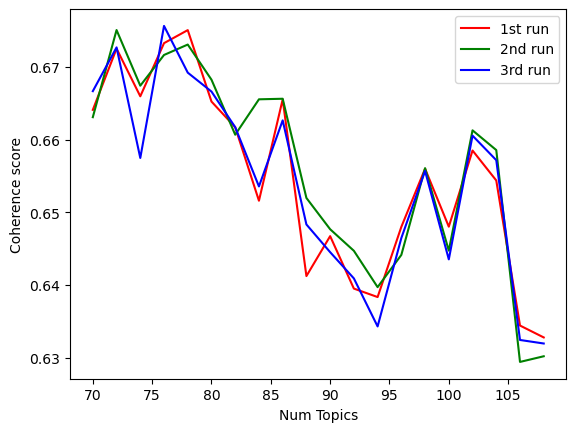

In [109]:
# Plot for each run 
limit = 110
start = 70
step = 2

x = range(start, limit, step)

# List of three lists
list1 = coherences[0]
list2 = coherences[1]
list3 = coherences[2]

# List of list names for the legend
list_names = ['1st run', '2nd run', '3rd run']

# List of colors for each list
colors = ['red', 'green', 'blue']

# Plot each list separately
for i, lst in enumerate([list1, list2, list3]):
    plt.plot(x, lst, color=colors[i])

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(list_names, loc='best')
plt.show()

# Co-occurence

In [14]:
# Create a list of countries 
all_countries = keywords["Country/Territory"].tolist()

#
countries_new=[]
for coun in all_countries:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            countries_new.append(c)
    else:
        countries_new.append(coun)

# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(countries_new))):
    countries[country_x]=i
    i+=1

In [15]:
topic_nums = np.arange(n_topics)

# topic sizes
topic_sizes = np.asarray(np.zeros(n_topics), dtype = 'int')

# list used to store all documents belonging to each individual topic 
documents_in_topics = [[] for _ in range(n_topics)]

for i in tqdm(range(len(corpus))): 
    topics = lda_model.get_document_topics(corpus[i])
    largest_prob = max(topics, key=lambda x: x[1])
    topic_max_prob = largest_prob[0]
    topic_sizes[topic_max_prob] += int(1)

    # fill out the list described above - to be used for further processing
    documents_in_topics[topic_max_prob].append((i, largest_prob[1]))




100%|██████████| 172392/172392 [00:14<00:00, 11514.89it/s]


In [134]:
# Sort the documents_in_topics list such that document with the highest probability of belonging to the respective topic
# is placed first in the corresponding sub-list. 

for sub_list in documents_in_topics:
    sub_list.sort(key=lambda x: x[1], reverse=True)

# Create a list as above without the probabilities (such that only the indices are used)
new_documents_in_topics = [[t[0] for t in sublist] for sublist in documents_in_topics]

In [132]:
# Compute country x topic occurence matrix
country_topic_matrix = np.zeros((len(set(countries_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    document_ids = new_documents_in_topics[num]
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(all_countries[id].split(";"))>=2:
            for c in all_countries[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[all_countries[id]],num] +=1

In [83]:
# Relevant function used in the next section
def square_rooted(x):
   return round(np.sqrt(sum([a*a for a in x])),3)

def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

In [84]:
def co_occurence(country_new, similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.exp(np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1])/np.exp(1)
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:])
    if similarity == "euclidean":
        country_co_occurrence=1-(country_co_occurrence/np.max(country_co_occurrence))
        
    return country_co_occurrence

country_co_occurrence = co_occurence(countries_new, "correlation")
np.shape(country_co_occurrence)

(257, 257)

In [85]:
#Remove small islands

for i in range(len(set(countries_new))):
    if countries_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country networks

In [86]:
# Importing packages to create networks 
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt

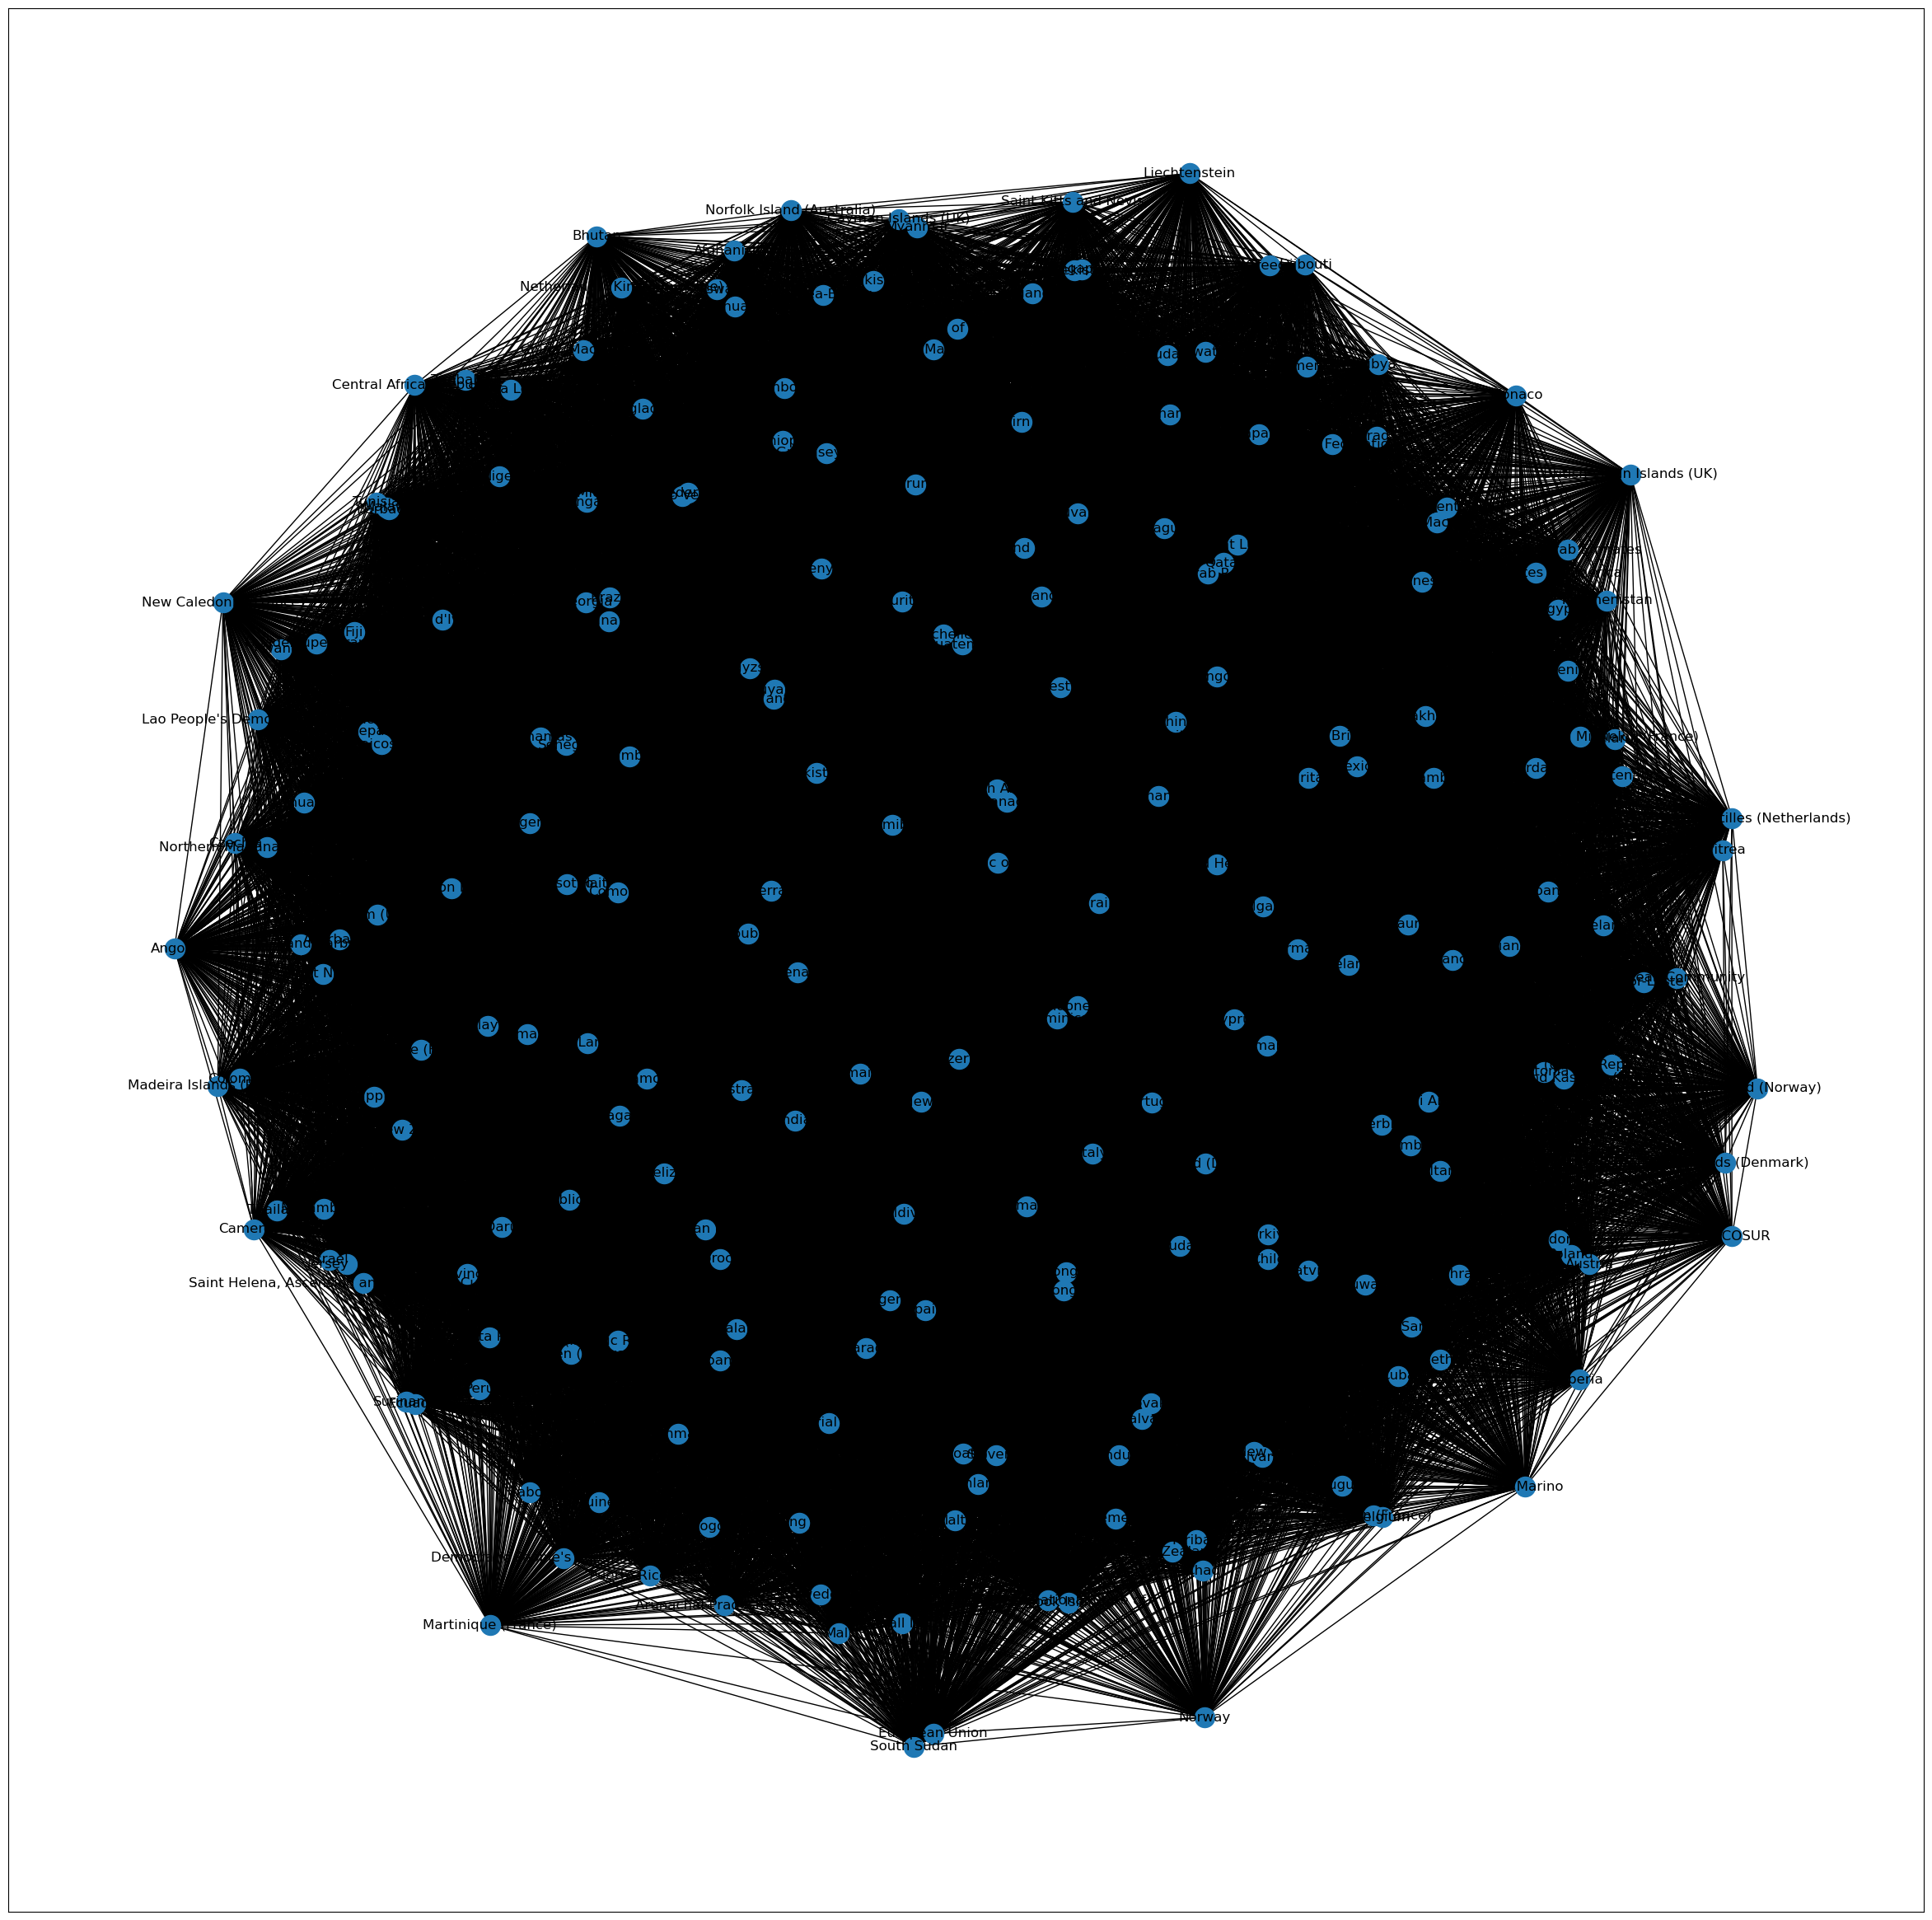

In [87]:
G = nx.Graph()

size = country_co_occurrence.shape[0]

countries_swap_copy = countries_swap.copy()

G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])

for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(30, 30))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

# Community detection

In [88]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.3,seed=69)
unique_coms = np.unique(list(comms))

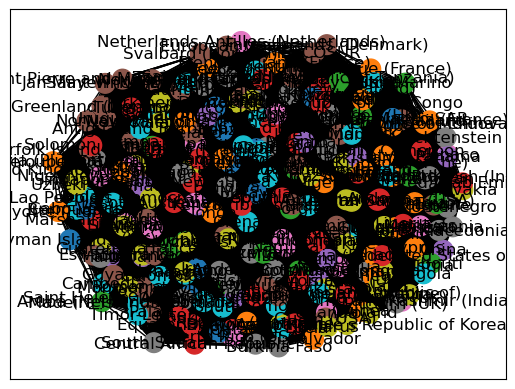

In [89]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
plt.show()


In [92]:
# print out communities
comms = louvain_communities(G,weight="weight",resolution=1.1796,seed=69)
unique_coms = np.unique(list(comms))
i=1
communities={}
for community in comms:
        print("c",i)
        com_countries = []
        for c in community:
            print(countries_swap[c])
            com_countries.append(c)
        communities[i] = com_countries
        i=i+1


c 1
Croatia
Spain
Nicaragua
Portugal
c 2
Jamaica
c 3
Zanzibar (United Republic of Tanzania)
Republic of Moldova
Taiwan Province of China
Cuba
El Salvador
Thailand
South Africa
c 4
Nigeria
United Republic of Tanzania
c 5
Myanmar
Malaysia
China
Bhutan
c 6
MERCOSUR
French Polynesia (France)
Andean Community
Lebanon
Aruba (Netherlands)
Egypt
Syrian Arab Republic
United Arab Emirates
Oman
c 7
Algeria
Djibouti
Tunisia
c 8
Guatemala
Paraguay
c 9
Côte d'Ivoire
Cameroon
Suriname
Democratic Republic of the Congo
Solomon Islands
Cambodia
Liberia
Gabon
Jammu and Kashmir (India)
Indonesia
Congo
Lao People's Democratic Republic
Central African Republic
c 10
Democratic People's Republic of Korea
Gambia
c 11
Comoros
Russian Federation
Papua New Guinea
c 12
Malawi
Zambia
Zimbabwe
Botswana
Kenya
c 13
Mexico
c 14
Norway
Jersey  (UK)
Faroe Islands (Denmark)
Mayotte (France)
Guinea-Bissau
British Virgin Islands (UK)
Saint Pierre and Miquelon (France)
Jan Mayen (Norway)
Palau
Réunion (France)
Tokelau (New Z

# Comparing communities to income-levels

In [93]:
#country-income data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [94]:
income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [95]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

Match: Madeira Islands (Portugal) - Portugal
Match: Gibraltar (UK) - Gibraltar
Match: Netherlands Antilles (Netherlands) - Netherlands
Match: Cayman Islands (UK) - Cayman Islands
Match: United States Virgin Islands - United States
Match: Clipperton Island (France) - France
Match: Bolivia (Plurinational State of) - Bolivia
Match: Taiwan Province of China - China
Match: Netherlands (Kingdom of the) - Netherlands
Match: Saint Kitts and Nevis - St. Kitts and Nevis
Match: Gambia - Gambia, The
Match: Svalbard (Norway) - Norway
Match: Norfolk Island (Australia) - Australia
Match: Jammu and Kashmir (India) - India
Match: United Kingdom of Great Britain and Northern Ireland - United Kingdom
Match: Greenland (Denmark) - Denmark
Match: Réunion (France) - France
Match: Aruba (Netherlands) - Aruba
Match: South Georgia and the South Sandwich Islands (UK) - Georgia
Match: Republic of Moldova - Moldova
Match: Bahamas - Bahamas, The
Match: Faroe Islands (Denmark) - Denmark
Match: Jan Mayen (Norway) - N

In [97]:
#manual_income =  [(0,3),(1,3),(5,3),(8,3),(12,3),(13,3),()]
for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [98]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',1),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]

for i,j in extra_countries:
    countries_income_dic[countries[i]]= j


In [99]:
# Compare countries income: function takes a list of country indexes and returns the rang between lowest and higest income country and the standard deviation
def check_income(community):
    com_income = []
    for i in community:
        com_income.append(countries_income_dic[i])
    range = max(com_income)-min(com_income)
    std = np.std(com_income)
    return range, std

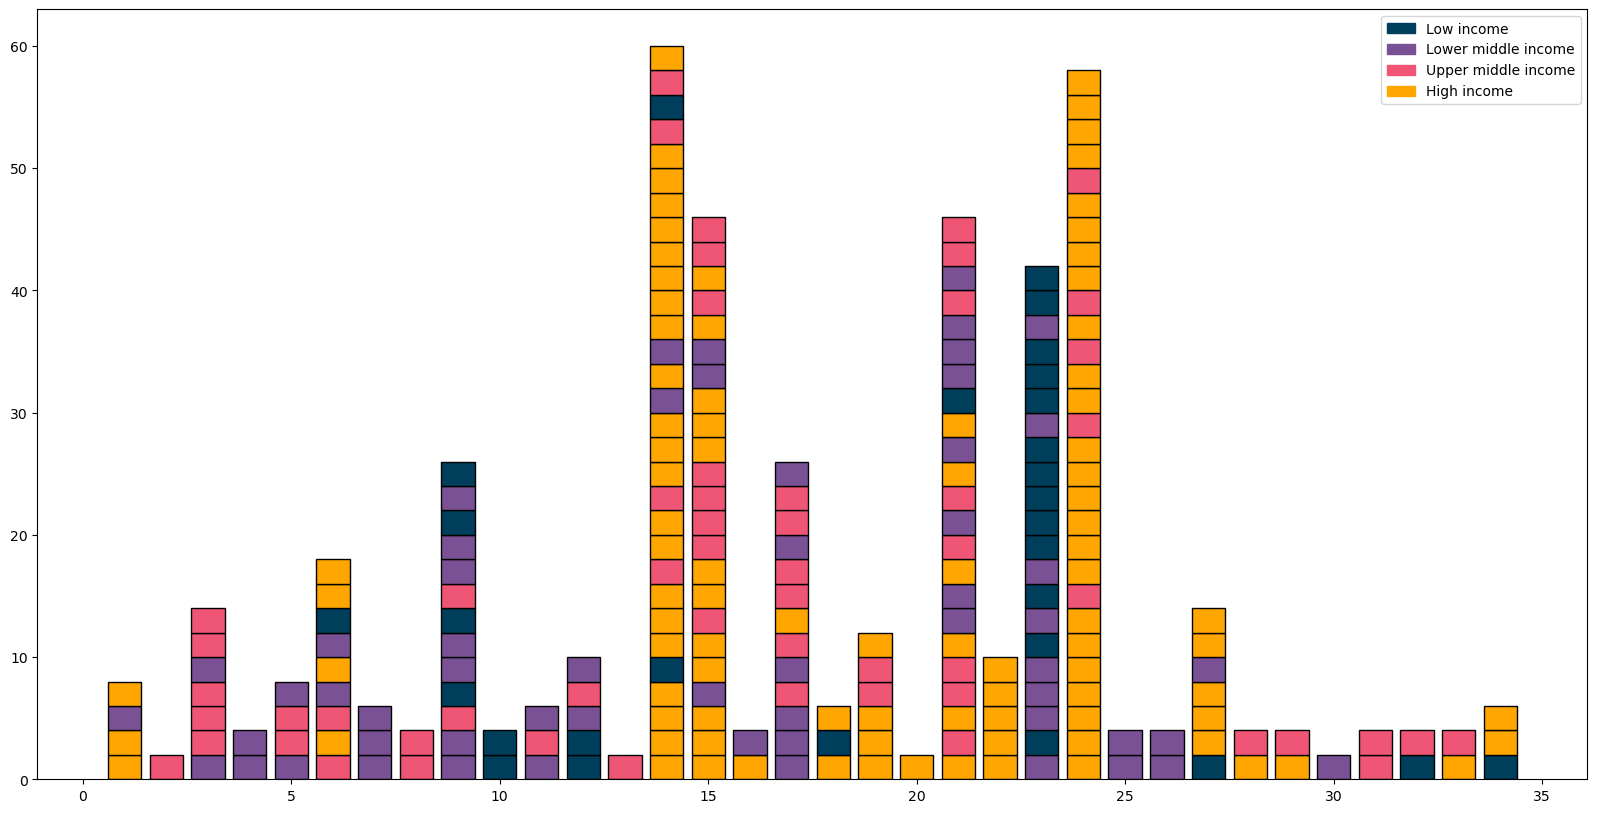

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(20, 10))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            h=2
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Low income")
pop_b = mpatches.Patch(color='#7a5195', label="Lower middle income")
pop_c = mpatches.Patch(color='#ef5675', label="Upper middle income")
pop_d = mpatches.Patch(color='#ffa600', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])


# Word cloud visualization

In [173]:
from wordcloud import WordCloud

In [153]:
# Get the topics which most topics are categorized as. 
indices = np.argsort(topic_sizes)[-5:][::-1]
print(indices)

[59 49 25 13 72]


In [194]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic, topn = 50)}
    wc = WordCloud(background_color="white", max_words=50, width=1600, height = 800)
    wc.generate_from_frequencies(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

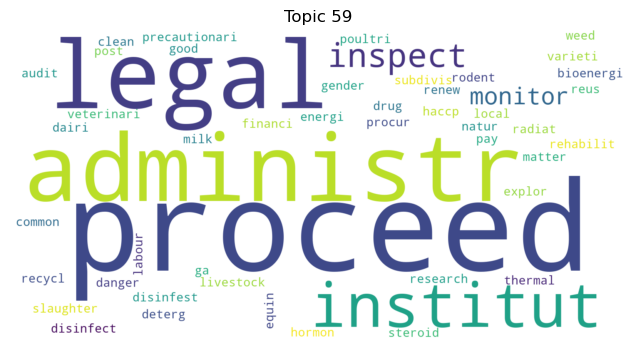

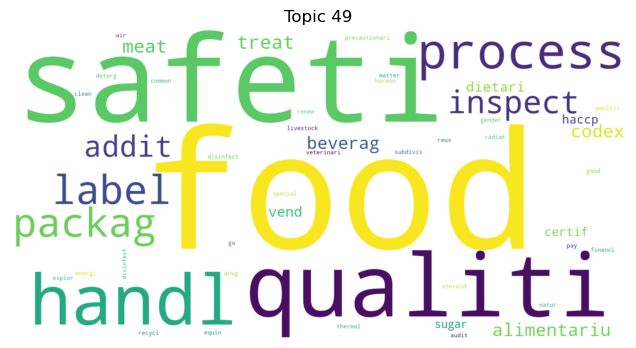

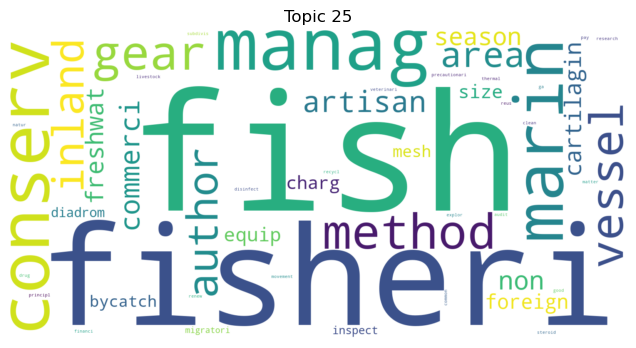

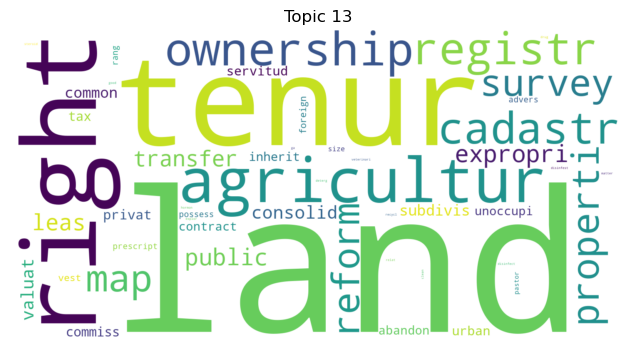

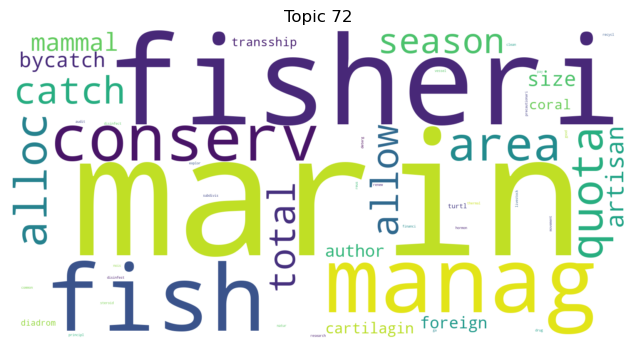

In [195]:
for topic in indices:
    create_wordcloud(lda_model, topic)

# Classifier to determine num_topics

In [52]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

In [43]:
# Proper way to do it
feature_vectors = []
country = keywords["Country/Territory"].tolist()
country_all = []
for i in tqdm(range(len(corpus))):
    if len(country[i].split("; "))>=2:
        for j in range(len(country[i].split("; "))):
            topic_probs = lda_model.get_document_topics(corpus[i], minimum_probability=0)
            probs = [t[-1] for t in topic_probs]
            feature_vectors.append(probs)
            country_all.append(country[i].split("; ")[j])
    else:
        topic_probs = lda_model.get_document_topics(corpus[i], minimum_probability=0)
        probs = [t[-1] for t in topic_probs]
        feature_vectors.append(probs) 
        country_all.append(country[i])


100%|██████████| 172392/172392 [00:10<00:00, 15770.61it/s]


In [37]:
# Don't do it this way; i just created this because I needed a number to be used in the report
feature_vectors = []
for i in tqdm(range(len(corpus))):
    topic_probs = lda_model.get_document_topics(corpus[i], minimum_probability=0)
    probs = [t[-1] for t in topic_probs]
    feature_vectors.append(probs)

100%|██████████| 172392/172392 [00:10<00:00, 16276.17it/s]


In [42]:
labels = keywords["Country/Territory"].tolist()
len(set(labels))

2029

In [45]:
# lda_model.get_document_topics(corpus[9], minimum_probability=0)

In [62]:
labels = country_all
# Encode labels in order to use frame in a classication framework
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [81]:
len(labels)

179019

In [15]:
label_encoder = LabelEncoder()

In [68]:
# Make train/test split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size = 0.3)

In [69]:
len(X_train)

125313

In [70]:
# Make RF classifier 
clf = RandomForestClassifier(n_estimators = 100, max_depth=30, max_features="sqrt")
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30)

In [71]:
y_pred = clf.predict(X_test)

In [73]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
# The accuracy of the model using the LDA model on 5 topics was 0.19990783152720368

ACCURACY OF THE MODEL:  0.20506088705172607


In [26]:
# Make KNN classifier 
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)
y_pred_knn = neigh.predict(X_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_knn))


ACCURACY OF THE MODEL:  0.2477935426209362


In [31]:
# Baseline
from collections import Counter
counter = Counter(encoded_labels)
most_common_element, occurrence_count = counter.most_common(1)[0]
print(f"The element that appears most often is: {most_common_element}")
print(f"It appears {occurrence_count} times.")
print(f"The baseline is thus {occurrence_count/len(feature_vectors)}")

The element that appears most often is: 189
It appears 9161 times.
The baseline is thus 0.051173339142772556


In [77]:
# Stratified CV: 
X = np.array(feature_vectors)
y = np.array(labels)
clf = RandomForestClassifier(n_estimators = 90, max_depth=30, max_features="sqrt")
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=11)
accu_stratified = []
for train_index, test_index in kfold.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    clf.fit(x_train_fold, y_train_fold)
    accu_stratified.append(clf.score(x_test_fold, y_test_fold))

/Users/jonathansimonsen/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [79]:
print('Overall Accuracy:', np.mean(accu_stratified))
print('List of possible accuracy:', accu_stratified)

Overall Accuracy: 0.21191047349013695
List of possible accuracy: [0.21284772651100436, 0.21340632331583062, 0.20842363981678025, 0.21296420431693255]


In [11]:
def compute_models(dictionary, corpus, topics):
    model_list = []
    for topic_n in tqdm(topics):
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes = 5)
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes=15)
        model_list.append(model)
    
    return model_list

In [12]:
def compute_rf_acc(lda_model):
    feature_vectors = []
    country = keywords["Country/Territory"].tolist()
    country_all = []
    for i in range(len(corpus)):
        if len(country[i].split("; "))>=2:
            for j in range(len(country[i].split("; "))):
                topic_probs = lda_model.get_document_topics(corpus[i], minimum_probability=0)
                probs = [t[-1] for t in topic_probs]
                feature_vectors.append(probs)
                country_all.append(country[i].split("; ")[j])
        else:
            topic_probs = lda_model.get_document_topics(corpus[i], minimum_probability=0)
            probs = [t[-1] for t in topic_probs]
            feature_vectors.append(probs) 
            country_all.append(country[i])

    labels = country_all
    encoded_labels = label_encoder.fit_transform(labels)

    # Stratified CV: 
    X = np.array(feature_vectors)
    y = np.array(encoded_labels)
    clf = RandomForestClassifier(n_estimators = 80, max_depth=30, max_features="sqrt")
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=11)
    accu_stratified = []
    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        accu_stratified.append(clf.score(x_test_fold, y_test_fold))

    accuracy = np.mean(accu_stratified)
    return accuracy
    

In [13]:
# Train LDA models
dictionary = id2word
corpus = corpus
topics = [19, 31, 60, 80, 100, 120]

model_list = compute_models(dictionary=id2word, corpus=corpus, topics=topics)

100%|██████████| 6/6 [1:03:40<00:00, 636.78s/it] 


In [16]:
# Get classification-accuracies of the models
accuracies = {topic_n: 0 for topic_n in topics}

for i in tqdm(range(len(model_list))): 
    accuracy = compute_rf_acc(model_list[i])
    key = list(accuracies.keys())[i]
    accuracies[key] = accuracy



  0%|          | 0/6 [00:00<?, ?it/s]/Users/jonathansimonsen/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
  0%|          | 0/6 [01:38<?, ?it/s]


KeyboardInterrupt: 

In [110]:
accuracies

{5: 0.2088269959119161, 7: 0.21704399909540123, 9: 0.22062463856400266}

In [ ]:
coherence_values_cv = []
coherence_values_umass = []
for model in model_list:
    # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes = 5)
    coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values_cv.append(coherencemodel.get_coherence())
    coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence_values_umass.append(coherencemodel.get_coherence())